<a href="https://colab.research.google.com/github/wahid028/Sentiment-Analysis/blob/main/BERT_model_changing_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install kaggle
!pip install -q kaggle

#upload the kaggle.json file
from google.colab import files
files.upload()

#create a kaggle directory
!mkdir ~/.kaggle

#copy the kaggle.json to kaggle directory
!cp kaggle.json ~/.kaggle/

#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c tweet-sentiment-extraction

 72% 1.00M/1.39M [00:00<00:00, 1.14MB/s]
100% 1.39M/1.39M [00:00<00:00, 1.48MB/s]


In [3]:
!unzip tweet-sentiment-extraction.zip

Archive:  tweet-sentiment-extraction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
! pip install nltk
! pip install spacy
! pip install beautifulsoup4
! pip install regex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 37.4 MB/s eta 0:00:00


In [ ]:
# !pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [7]:
#print bold text
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [8]:
import pandas as pd
import numpy as np
import pandas as pd
import nltk
import spacy
import re
from bs4 import BeautifulSoup
nltk.download("all")

import torch
import tensorflow as tf
import gc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


from transformers import AutoTokenizer
from transformers import BertTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [9]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [10]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [11]:
df = pd.read_csv('../content/train.csv')

In [12]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [13]:
# drop the rows with neutral sentiment as we are only interested in positive and negative sentiment
df = df[df['sentiment'] != 'neutral']
df = df.reset_index(drop=True)

In [14]:
df = df[['text','sentiment']]

In [15]:
#sentiment converter
def sentiment_ts(sentiment):
    if sentiment == 'negative':
        return 0
    elif sentiment == 'positive':
        return 1
    
df['label'] = df['sentiment'].apply(sentiment_ts)

In [16]:
df.head()

,text,sentiment,label
0,Sooo SAD I will miss you here in San Diego!!!,negative,0
1,my boss is bullying me...,negative,0
2,what interview! leave me alone,negative,0
3,"Sons of ****, why couldn`t they put them on t...",negative,0
4,2am feedings for the baby are fun when he is a...,positive,1


In [17]:
df = df[['text','label']]

Text Pre-processing

In [18]:
#load the spacy model and functions related to stop words modification
spacy_model = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
# print(spacy_model.Defaults.stop_words) #print the default stop words list
# spacy_model.Defaults.stop_words.remove("whatever") #remove single stop word from the list
# spacy_model.Defaults.stop_words -= {"whatever", "whenever"} #remove several stop words from the list
spacy_model.Defaults.stop_words.add("4am") #add single stop word in the default list
# spacy_model.stop_words |= {"my_new_stopword1","my_new_stopword2"} #add several stop words in the default list

In [19]:
#most widely used shortforms are in the internet for social media data
contra_Expan_Dict = {
"ain`t": "am not","aren`t": "are not","can`t": "cannot","can`t`ve": "cannot have","`cause": "because",
"could`ve": "could have","couldn`t": "could not","couldn`t`ve": "could not have","didn`t": "did not",
"doesn`t": "does not","don`t": "do not","hadn`t": "had not","hadn`t`ve": "had not have","hasn`t": "has not",
"haven`t": "have not","he`d": "he would","he`d`ve": "he would have","he`ll": "he will","he`ll`ve": "he will have",
"he`s": "he is","how`d": "how did","how`d`y": "how do you","how`ll": "how will",
"how`s": "how does","i`d": "i would","i`d`ve": "i would have","i`ll": "i will","i`ll`ve": "i will have","i`m": "i am",
"i`ve": "i have","isn`t": "is not","it`d": "it would","it`d`ve": "it would have","it`ll": "it will","it`ll`ve": "it will have",
"it`s": "it is","let`s": "let us","ma`am": "madam","mayn`t": "may not","might`ve": "might have","mightn`t": "might not",
"mightn`t`ve": "might not have","must`ve": "must have","mustn`t": "must not","mustn`t`ve": "must not have","needn`t": "need not","needn`t`ve": "need not have",
"o`clock": "of the clock","oughtn`t": "ought not","oughtn`t`ve": "ought not have","shan`t": "shall not",
"sha`n`t": "shall not","shan`t`ve": "shall not have","she`d": "she would",
"she`d`ve": "she would have","she`ll": "she will","she`ll`ve": "she will have",
"she`s": "she is","should`ve": "should have","shouldn`t": "should not","shouldn`t`ve": "should not have","so`ve": "so have","so`s": "so is",
"that`d": "that would","that`d`ve": "that would have","that`s": "that is","there`d": "there would","there`d`ve": "there would have","there`s": "there is",
"they`d": "they would","they`d`ve": "they would have","they`ll": "they will","they`ll`ve": "they will have","they`re": "they are","they`ve": "they have",
"to`ve": "to have","wasn`t": "was not"," u ": " you "," ur ": " your "," n ": " and ","won`t": "would not",
"dis": "this","bak": "back","brng": "bring","sooo": "so", "afaik" :"as far as i know",
"afk" :"away from keyboard","asap" :"as soon as possible","atk" :"at the keyboard","atm" :"at the moment","a3" :"anytime, anywhere, anyplace",
"bak" :"back at keyboard","bbl" :"be back later","bbs" :"be back soon","bfn" :"bye for now","b4n" :"bye for now","brb" :"be right back",
"brt" :"be right there","btw" :"by the way","b4" :"before","b4n" :"bye for now","cu" :"see you","cul8r" :"see you later",
"cya" :"see you","faq" :"frequently asked questions","fc" :"fingers crossed","fwiw" :"for what it's worth","fyi" :"for your information",
"gal" :"get a life","gg" :"good game","gn" :"good night","gmta" :"great minds think alike","gr8" :"great!","g9" :"genius",
"ic" :"i see","icq" :"i seek you (also a chat program)","ilu" :"ilu: i love you","imho" :"in my honest/humble opinion","imo" :"in my opinion","iow" :"in other words",
"irl" :"in real life","kiss" :"keep it simple, stupid","ldr" :"long distance relationship","lmao" :"laugh my a.. off","lol" :"laughing out loud",
"ltns" :"long time no see","l8r" :"later","mte" :"my thoughts exactly","m8" :"mate","nrn" :"no reply necessary","oic" :"oh i see",
"pita" :"pain in the a..","prt" :"party","prw" :"parents are watching","qpsa?   que pasa?" :"","rofl" :"rolling on the floor laughing",
"roflol" :"rolling on the floor laughing out loud","rotflmao" :"rolling on the floor laughing my ass off","sk8" :"skate","stats" :"your sex and age",
"asl" :"age, sex, location","thx" :"thank you","ttfn" :"ta-ta for now!","ttyl" :"talk to you later",
"u" :"you","u2" :"you too","u4e" :"yours for ever","wb" :"welcome back","wtf" :"what the fuck","wtg" :"way to go!",
"wuf" :"where are you from?","w8" :"wait","7k" :"sick:-d laugher", "w/out": "without", "ihavent": "i have not", "bday": "birthday", "im": "i am"}

In [20]:
#function for converting shortforms to it's expanded form based on contra_Expan_Dict
def expanded_form(x):
  if x in contra_Expan_Dict.keys():
    return(contra_Expan_Dict[x])
  else:
    return(x)

In [21]:
#function for removing url punctuations and digits
def clean_with_re(x):
  x=str(x)
  x=re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'," ", x) #Remove URLs
  x=re.sub(r'[^\w ]+', "", x) # Remove Punctuation-1
  x=re.sub(r"[,!@&\'?\.$%_]"," ", x) # Remove Punctuation-2
  x=re.sub(r"\d+"," ", x) #Remove digits
  return(x)

In [22]:
#function for removing HTML Tags
def remove_html(text):
    return BeautifulSoup(text, "lxml").text

In [23]:
#function for counting the words
from collections import Counter
cnt = Counter()
for text in df["text"].values:
    for word in text.split():
        cnt[word] += 1

#function for removing the most frequent words
cnt.most_common(10)
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

#function for removing the most rare words
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

In [24]:
#remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [25]:
#function for removing duplicate white spaces
def remove_duplicate_ws(x):
  x=str(x)
  x=" ".join(re.split("\s+", x, flags=re.UNICODE))
  return(x)

In [26]:
def pre_processing(input_data, text_col):
  #convert all the input texts into lower case.
  input_data["text_col_clean"]=input_data[text_col].apply(lambda x:str(x).lower())
  #convert all the shortform of the input texts to its expanded form.
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:[expanded_form(t) for t in str(x).split()])
  #remove the stopwords based on spacy default package
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:[t for t in x if t not in spacy_stopwords])
  #remove the url, punctuations and digits from the input text
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:clean_with_re(x))
  #remove the HTML Tags from the input text
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_html(x))
  #lemmatization - converting evary word to it's root form
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:" ".join([t.lemma_ for t in spacy_model(str(x))if t.lemma_ !="-PRON-" ]))
  #remove the most frequents words
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_freqwords(x))
  #remove the most rare words
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_rarewords(x))
  #remove the emojis
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_emoji(x))
  #remove the duplicate whitespace.
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:remove_duplicate_ws(x))

In [27]:
#call the pre_processing function
pre_processing(input_data=df, text_col="text")

In [28]:
#check random text before and after pre-processing
print("Before Pre-processing: ",df["text"][401])
print("After Pre-processing: ",df["text_col_clean"][401])
#print the sentence length before and after pre-processing
print("Before Pre-processing: ",len(df["text"][401].split()))
print("After Pre-processing: ",len(df["text_col_clean"][401].split()))
#print the sentiment of the text
print("Sentiment of the text: ",df["label"][401])

Before Pre-processing:   ...i`m sorry about you are still sick  u know most of them, AND i know that u will guess the 'pelzer present' ;-)
After Pre-processing:  m sorry sick know they know guess pelzer present
Before Pre-processing:  23
After Pre-processing:  9
Sentiment of the text:  0


Creating new dataset for further processing

In [29]:
#create new dataframe with text_col_clean and label
df_new = df[['text_col_clean','label']]
df_new.head()

,text_col_clean,label
0,sad miss san diego,0
1,boss bully,0
2,interview leave,0
3,son could not release buy,0
4,be feeding baby fun smile coo,1


In [30]:
#check the NA values
df.isnull().sum()

text              0
label             0
text_col_clean    0
dtype: int64

In [31]:
# convert data set into required data type
df_new['text_col_clean'] = df_new['text_col_clean'].astype(str)
df_new['label'] = df_new['label'].astype('int32')

In [32]:
df_new.dtypes

text_col_clean    object
label              int32
dtype: object

In [33]:
#how much memore is used for the dataset
print("'\n==== For initial dataset ====\n'")
print(df.memory_usage(deep=True))
printmd('**Total memory usage:**')
print(df.memory_usage().sum())
print("'\n==== For updated dataset ====\n'")
print(df_new.memory_usage(deep=True))
printmd('**Total memory usage:**')
print(df_new.memory_usage().sum())

'
==== For initial dataset ====
'
Index                 128
text              2087368
label              130904
text_col_clean    1597122
dtype: int64


**Total memory usage:**

392840
'
==== For updated dataset ====
'
Index                 128
text_col_clean    1597122
label               65452
dtype: int64


**Total memory usage:**

196484


In [ ]:
# #delete the original dataframe
# del df

# #check the gpu memory usage
# !nvidia-smi

In [34]:
# Get the lists of sentences and their labels.
sentences = df_new.text_col_clean.values
labels = df_new.label.values

Split the dataset

In [35]:
from sklearn.model_selection import train_test_split

X = df_new['text_col_clean']
y = df_new['label']

# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(X, y, random_state=2018, test_size=0.3, stratify=y)
# split validation dataset into validation and test sets
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)

In [36]:
len(test_text)

2455

Mean length of sentence:  7.261917234154008
Max length of sentence:  26


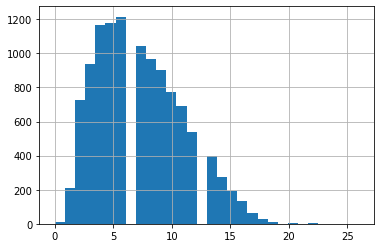

In [37]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
print("Mean length of sentence: ",np.mean(seq_len))
print("Max length of sentence: ",max (seq_len))

Tokeninzation and Encoding

In [45]:
#import tokenizer
from transformers import BertTokenizer

model_ckpt = "bert-base-uncased"
num_labels = 2 #need to modify based on our dataset (positive, negative, neutral)

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_ckpt, do_lower_case=True)

Loading BERT tokenizer...


In [46]:
# tokenize and encode sequences in the training set, validation set and test set

max_length = 64

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_length,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_length,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_length,
    pad_to_max_length=True,
    truncation=True
)

In [47]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [48]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
validation_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
prediction_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during testing
prediction_sampler = SequentialSampler(prediction_data)

# dataLoader for train set
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [49]:
#checking the tokenizer is working or not

# Print the original sentence.
print('Original: ', sentences[401])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[401]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[401])))

Original:  m sorry sick know they know guess pelzer present
Tokenized:  ['m', 'sorry', 'sick', 'know', 'they', 'know', 'guess', 'pe', '##lz', '##er', 'present']
Token IDs:  [1049, 3374, 5305, 2113, 2027, 2113, 3984, 21877, 23858, 2121, 2556]


Custom model

In [63]:
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch.nn as nn

In [68]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 176 µs, sys: 0 ns, total: 176 µs
Wall time: 183 µs


In [69]:
model=BertClassifier().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [70]:
# Tell pytorch to run this model on the GPU.
model.cuda()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [71]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 203 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

Optimizer & Learning Rate Scheduler

In [81]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Training Loop

In [82]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [83]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [84]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [86]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, validation_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.641641   |     -      |     -     |   6.62   
   1    |   40    |   0.409367   |     -      |     -     |   6.34   
   1    |   60    |   0.318541   |     -      |     -     |   6.34   
   1    |   80    |   0.319599   |     -      |     -     |   6.40   
   1    |   100   |   0.319637   |     -      |     -     |   6.45   
   1    |   120   |   0.298874   |     -      |     -     |   6.48   
   1    |   140   |   0.275766   |     -      |     -     |   6.50   
   1    |   160   |   0.295609   |     -      |     -     |   6.56   
   1    |   180   |   0.276618   |     -      |     -     |   6.69   
   1    |   200   |   0.305067   |     -      |     -     |   6.65   
   1    |   220   |   0.303576   |     -      |     -     |   6.70   
   1    |   240   |   0.302821   |     -      |     -     |   6.73   


Evaluation on Validation Set

In [87]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [88]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9611
Accuracy: 89.89%


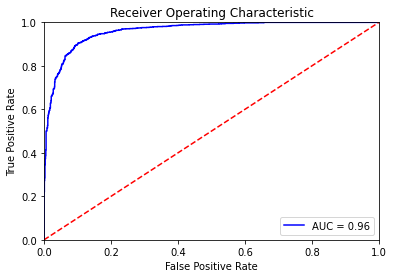

In [89]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, validation_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, val_labels)

Train Our Model on the Entire Training Data

In [90]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.628894   |     -      |     -     |   6.61   
   1    |   40    |   0.394825   |     -      |     -     |   6.31   
   1    |   60    |   0.341266   |     -      |     -     |   6.36   
   1    |   80    |   0.317997   |     -      |     -     |   6.42   
   1    |   100   |   0.343848   |     -      |     -     |   6.47   
   1    |   120   |   0.299944   |     -      |     -     |   6.51   
   1    |   140   |   0.302724   |     -      |     -     |   6.53   
   1    |   160   |   0.290827   |     -      |     -     |   6.58   
   1    |   180   |   0.291436   |     -      |     -     |   6.62   
   1    |   200   |   0.263179   |     -      |     -     |   6.66   
   1    |   220   |   0.304123   |     -      |     -     |   6.70   
   1    |   240   |   0.299629   |     -      |     -     |   6.74   
